In [1]:
import networkx as nx
import numpy as np
from numpy.random import choice, rand 
import numpy as np
import matplotlib.pyplot as plt

#from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from scipy.sparse import lil_matrix, csr_matrix, find
np.random.seed(42)

# Previous Code


In [2]:
def infection(m,beta):
    infection_probability = 1 - (1-beta)**m
    return 1 if np.random.rand(1)[0] <= infection_probability else 0

def recovery(p):
    return 1 if np.random.rand(1)[0] >= p else 0

def init_stats(duration,state):
    st = np.zeros([duration,state.shape[0]])
    stats = lil_matrix(st,shape=(duration,state.shape[0]),dtype=int) #faster sparse matrix creation/population
    stats[0,:] = state
    return stats

def group_sum(stats,row):
    previous_state = np.array(find(stats.getrow(row)))[1:]
    zeros = stats.shape[1]-previous_state.shape[1]
    count = {0:zeros}
    for idx in range(previous_state.shape[1]):
        node = previous_state[0,idx]
        value = previous_state[1,idx]
        count[value] = count.get(value,0) + 1
    return count
    
    
def count_new_state_increment(stats,moment, key=1):
    split = stats[moment-1:moment+1,:]
    cii = 0
    for n in range(split.shape[1]):
        if split[1,n] == key and split[0,n] != key:
            cii += 1
    return cii
            


def epidemic_simulation(G,model,state,duration,beta,p,vaccination=None):
    stats = init_stats(duration,state)
    if vaccination:
        vaccinated = np.array([])
    for moment in range(1,duration):
        if vaccination:
            vaccines = int((vaccination[moment]-vaccination[moment-1])/100 *state.shape[0])
            to_be_vaccinated = choice([x for x in range(state.shape[0]) if x not in vaccinated], vaccines, replace=False)
            for vac in to_be_vaccinated:
                stats[moment:,vac] = 3
            vaccinated = np.concatenate([vaccinated,to_be_vaccinated])
        for node in G.nodes:
            if stats[moment,node] == 3:
                continue
            node_state = stats[moment-1,node]
            if node_state == 0: #susceptible
                neighbors = [n for n in G.neighbors(node)]
                infected_neighbors = [stats[moment-1,x] for x in neighbors].count(1)#group_sum(stats,moment,1,neighbors)
                stats[moment,node] = infection(infected_neighbors,beta)
            elif node_state == 1: #infected
                recovered = recovery(p)
                stats[moment,node] = node_state + recovery(p)
                if recovered > 0: #recovered
                    stats[moment:,node] = 2
            else:
                continue
                
    stats = csr_matrix(stats) #faster sparse matrix computation
    return stats

def multiple_simulation(G,model,state,duration,beta,p,num,vaccination=None, plot=True):
    stats = epidemic_simulation(G,model,state,duration,beta,p,vaccination)
    for i in range(1,num):
        stats = np.column_stack((stats,epidemic_simulation(G,model,state,duration,beta,p,vaccination)))
    ev_rate = compute_evolution(stats,duration,vaccination)
    if plot:
        duration = range(duration)
        return plot_avg_state(ev_rate,duration,vaccination)
    else: 
        return ev_rate

def compute_evolution(stats,duration,vaccination=None):
    initial_step = group_sum(stats[0,0],0)
    initial_state = np.zeros(4 + (2 if vaccination else 0))
    for k,v in initial_step.items():
        initial_state[k] = v
    initial_state[-1] = initial_step[1]
    evolution_rate = initial_state
    for moment in range(1,duration):
        if vaccination:
            avg_state = np.zeros(6)
        else:
            avg_state = np.zeros(4)
        for simulation in range(0,stats.shape[1]):
            count = group_sum(stats[0,simulation],moment)
            for k,v in count.items():
                avg_state[k] += v
            avg_state[-1] += count_new_state_increment(stats[0,simulation],moment)
            if vaccination:
                avg_state[-2] += count_new_state_increment(stats[0,simulation],moment,key=3)
        avg_state = avg_state / stats.shape[1]
        evolution_rate = np.column_stack((evolution_rate, avg_state))
    return evolution_rate
        
        
def plot_avg_state(evolution_rate,duration,vaccination=None):
    #evolution_rate = compute_evolution(stats,duration,vaccination)
    ig, ax= plt.subplots(figsize=(10,7))
    ax.plot(duration, evolution_rate[0,:], label='S')
    ax.plot(duration, evolution_rate[1,:], label='I')
    ax.plot(duration, evolution_rate[2,:], label='R')
    if vaccination:
        ax.plot(duration, evolution_rate[3,:], label='Vaccinated')
        ax.plot(duration, evolution_rate[-2,:], label='New Vaccines')
    ax.plot(duration, evolution_rate[-1,:], label='New Infections')
    ax.set(xlabel='time (weeks)',ylabel='folks', title='Epidemic simulation')
    ax.legend(loc='best');
    return evolution_rate
    #print(evolution_rate)

def RMSE(i,i_true):
    return np.sqrt(1/i.shape[0]*sum((i-i_true)**2))

def search_pandemic(tested_hp,N,model,params,i_true,state,duration,num,vaccination=None,best_res=None):
    grid = ParameterGrid(params)
    best_res = None
    for params in grid:
        if(params in tested_hp):
            continue
        else:
            tested_hp.append(params)
        rg = RandomGraphGenerator(N,params['k'])
        ev_rate = multiple_simulation(rg.G,model,state,simulation_time,params['b'],params['p'],attempts,vacc,plot=False)
        newly_inf = ev_rate[-1,:]
        result = RMSE(newly_inf,i_true)
        if not best_res or result < best_res[0]:
            best_res = [result,ev_rate,params]
    return best_res, tested_hp

def plot_newly_infected(duration,i,i_true):
    ig, ax= plt.subplots(figsize=(10,7))
    ax.plot(duration, i, label='New Infected (Simulation)')
    ax.plot(duration, i_true, label='New Infected (GT)')
    ax.set(xlabel='time (weeks)',ylabel='folks', title='hp comparison (k,p,b)')
    ax.legend(loc='best');
    
        
def parameters_search(N,paramatrix,model,params,i_true,state,duration,num,vaccination=None):
    tested_hp = []
    best_res = None
    while True:
        params = validate_params(paramatrix)
        print(params)
        sc_stat_par,tested_hp = search_pandemic(tested_hp,N,SIR,params,NI_true,status,simulation_time,attempts,vacc,best_res)
        if not best_res or sc_stat_par[0] < best_res[0]:
            paramatrix[0,:] = sc_stat_par[2]['k'],sc_stat_par[2]['b'],sc_stat_par[2]['p']
            best_res = sc_stat_par
        elif sc_stat_par[2] == best_res[2] and paramatrix[1,1] >= 0.1:
            paramatrix[1,1:] /= 2
        elif sc_stat_par[0] > best_res[0]:
            break
            
    plot_avg_state(best_res[1],range(duration),vaccination)
    plot_newly_infected(range(duration),best_res[1][-1,:],i_true)
    print(best_res[0],best_res[2])
    
def validate_param(vals,lb=0,ub=1,integ=False):
    valval = []
    for v in vals:
        if v < lb:
            v = lb
        elif v > ub:
            v = ub
        if integ:
            v = int(v)
        valval.append(v)
    return valval
    
def validate_params(paramatrix):
    k0, b0, p0 = paramatrix[0,:]
    dk, db, dp = paramatrix[1,:]
    params = {
        'k': validate_param([k0-dk, k0, k0+dk],2,934,True),
        'b': validate_param([b0-db, b0, b0+db]),
        'p': validate_param([p0-dp, p0, p0+dp])
    }
    return params
    

# Random graph
Configuration model with grades distributed accordingly to a normal distribution

In [ ]:
class RGConfModel():
  def __init__(self,N,mu,sigma=None):
    self.N = N
    self.mu = mu
    self.sigma = sigma if sigma else mu/4
    self.WCM = np.zeros((N,N))
    self.available_targets = np.arange(N)
    self.residual_degrees = None
    self.G = None
    self.init_graph_distribution()
    self.init_graph()
    

  def init_graph(self):
    #self.print(self.residual_degrees)
    for i in range(self.N):
      # a target is available if its residual in degree is positive
      available_targets = np.argwhere(self.residual_degrees > 0).flatten()
      if available_targets.shape[0] == 0:
        break
      # randomly connect the link to the targets
      targets = np.random.choice(available_targets,self.residual_degrees[i], [self.available_targets/np.sum(self.residual_degrees)])
      self.residual_degrees[i] -= targets.shape[0]
      for target in targets:
        if self.residual_degrees[target] < 1:
          available_targets = self.available_targets[np.argwhere(self.residual_degrees > 0)].flatten()
          if available_targets.shape[0] == 0:
            break
          #self.print(available_targets)
          target = np.random.choice(available_targets,1)
        self.WCM[i,target] = 1
        self.WCM[target,i] = 1
        self.residual_degrees[target] -=1
    self.G = nx.from_numpy_array(self.WCM, create_using=nx.Graph)

  def init_graph_distribution(self):
    s = np.random.normal(self.mu, self.sigma, self.N) #Select a number through a normal distribution, given a mean and a standard deviation
    n = s.astype(np.int32) #Cast it to integer
    #self.print(np.sum(s)/s.shape[0],np.std(s, ddof=1),np.sum(n)/n.shape[0],np.std(n, ddof=1))
    n[n<1] = 1 #Check if the number of edges is suitable 
    nodes_to_add_remove = int(sum(s) - sum(n)) #adds randomly some connection in order to minimize the int cast error
    ex = np.random.choice(range(self.N), abs(nodes_to_add_remove)) #Inside all the possible nodes, select a number of nodes to add (for example, in N=100 nodes, take 8 nodes)
    for i in ex: #Iterate over the selected node
      if nodes_to_add_remove > 0:  
        n[i] += 1 
      else:
        if n[i] > 2: 
          n[i] -= 1
        else:
          while True:
            new_index = np.random.randint(self.N)
            if n[new_index] > 2:
              n[new_index] -= 1
              break
    #self.print(np.sum(n)/n.shape[0],np.std(n, ddof=1))
    self.residual_degrees = np.array(n)

  def print(self,*param):
    print(param)

  def draw(self):
    nx.draw(self.G)
  
  def draw_circular(self):
    pos = nx.circular_layout(self.G)
    nx.draw(self.G,pos)

3.6
1.4966629547095767


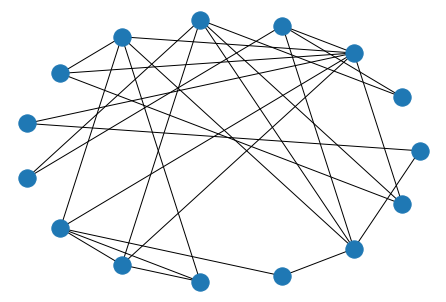

In [ ]:
test_graph = RGConfModel(15,4,3)
#test_graph.draw()
test_graph.draw_circular()
print(np.mean([test_graph.G.degree(x) for x in range(15)]))
print(np.std([test_graph.G.degree(x) for x in range(15)]))

In [ ]:
from sklearn.model_selection import ParameterGrid
N = 934
vacc = [5,9,16,24,32,40,47,54,59,60,60,60,60,60,60,60]
status = np.zeros(N,dtype=np.int32)
init_infected = choice(range(status.shape[0]),1)
status[init_infected] = 1
simulation_time = 16
attempts = 10
SIR = {'S':0,'I':1,'R':2, 'V':3}
NI_true = [1,1,3,5,9,17,32,32,17,5,2,1,0,0,0,0]
k0, b0, p0 = 10, 0.3, 0.6
dk, db, dp = 1, 0.1, 0.1
paramatrix = np.array([[k0,b0,p0],[dk,db,dp]])

[37]


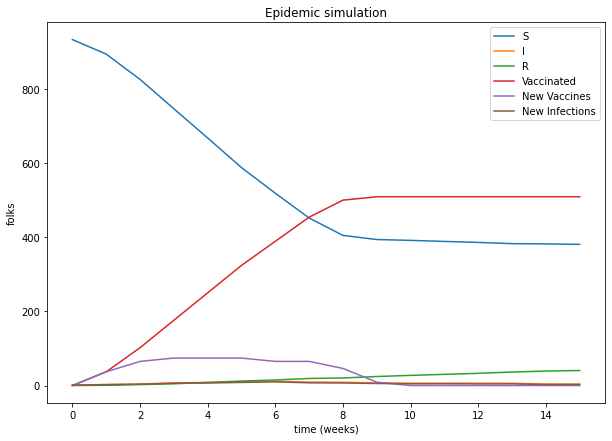

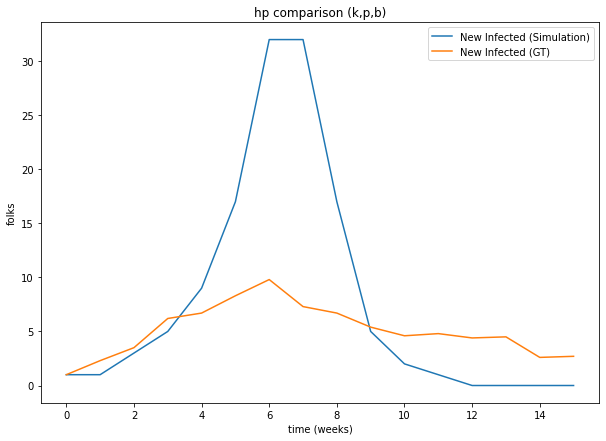

In [ ]:
vacc = [5,9,16,24,32,40,47,54,59,60,60,60,60,60,60,60]
NI_true = [1,1,3,5,9,17,32,32,17,5,2,1,0,0,0,0]
N = 934
k = 6
mu = 10
sigma = 1
CMG = RGConfModel(N,mu).G
#nx.draw(CMG)
status = np.zeros(N)
beta = 0.2
p = 0.5
simulation_time = 16 #weeks
attempts = 10
SIR = {'S':0,'I':1,'R':2}

init_infected = choice(CMG.nodes,1, replace=False)
for inf in init_infected:
    status[inf] = 1
print(init_infected)
ev_rate = multiple_simulation(CMG,SIR,status,simulation_time,beta,p,attempts,vacc)
plot_newly_infected(range(len(vacc)),NI_true,ev_rate[-1,:])

# Iterative random search

In [3]:
from sklearn.model_selection import ParameterGrid
from numpy import linspace
N = 934
vacc = [5,9,16,24,32,40,47,54,59,60,60,60,60,60,60,60]
status = np.zeros(N,dtype=np.int32)
init_infected = choice(range(status.shape[0]),1)
status[init_infected] = 1
simulation_time = 16
attempts = 5
SIR = {'S':0,'I':1,'R':2, 'V':3}
NI_true = [1,1,3,5,9,17,32,32,17,5,2,1,0,0,0,0]

def RMSE(i,i_true):
    return np.sqrt(1/i.shape[0]*sum((i-i_true)**2))

def plot3D(results):
  dataset = [x[2] for x in results]
  x = [x['mu'] for x in dataset]
  y = [y['b'] for y in dataset]
  z = [z['p'] for z in dataset]
  size = [30*s['sigma'] for s in dataset]
  color_score = np.log([x[0]+1 for x in results])

  fig,ax = plt.subplots(figsize=(15,10))
  ax = plt.axes(projection = '3d')
  ax.grid(b = True, color ='grey', 
        linestyle ='-.', linewidth = 0.3, 
        alpha = 0.2) 
  my_cmap = plt.get_cmap('viridis')
  sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = color_score, 
                    cmap = my_cmap, 
                    s = size,
                    marker ='o')
 
  plt.title("Parameter Space")
  ax.set_xlabel('Mu', fontweight ='bold') 
  ax.set_ylabel('Beta', fontweight ='bold') 
  ax.set_zlabel('Ro', fontweight ='bold')
  fig.colorbar(sctt, ax = ax, shrink = 0.3, aspect = 5)
  
  # show plot
  plt.show()






def plot_newly_infected(duration,i,i_true):
    ig, ax= plt.subplots(figsize=(10,7))
    ax.plot(duration, i, label='New Infected (Simulation)')
    ax.plot(duration, i_true, label='New Infected (GT)')
    ax.set(xlabel='time (weeks)',ylabel='folks', title='hp comparison (k,p,b)')
    ax.legend(loc='best');
    
'''
def choose_random_params(params,quantity=1,distribution=None):
  ps = {}
  for k,vs in params.items():
    ps[k] = choice(vs,quantity,distribution)[0]
  return ps
'''

def choose_random_params(params):
  ps = {}
  for k,vs in params.items():
    ps[k] = np.random.uniform(vs[0],vs[1])
  return ps

def iterative_random_search_simulation(k,q,prev_res,attempts,N,model,i_true,state,duration,vaccination=None):
  #prev_res, k best results, q random space points
  
  if prev_res:
    #print([x[2] for x in prev_res])
    results = prev_res[:]
    best_ress = sorted(results, key=lambda x: x[0])[:k]
    par_sp = [x[2] for x in best_ress]
    params_space = {
        'mu': [min(x['mu'] for x in par_sp),max(x['mu'] for x in par_sp)],
        'sigma': [min(x['sigma'] for x in par_sp),max(x['sigma'] for x in par_sp)],
        'p': [min(x['p'] for x in par_sp),max(x['p'] for x in par_sp)],
        'b': [min(x['b'] for x in par_sp),max(x['b'] for x in par_sp)],
    }
  else:
    results = []
    params_space = {
      'mu': [2,20],
      'sigma': [0,15],
      'p': [0,1],
      'b': [0,1],
    }
  print(params_space)
  for point in range(q):
    params = choose_random_params(params_space)
    CMG = RGSmallWorldModel(N,params['mu'],params['sigma']).G
    ev_rate = multiple_simulation(CMG,model,state,simulation_time,params['b'],params['p'],attempts,vacc,plot=False)
    newly_inf = ev_rate[-1,:]
    result = RMSE(newly_inf,i_true)
    results.append([result,ev_rate,params])
  
  return results


def research_random(iter,N,k,q,attempts,model,i_true,state,duration,vaccination=None):
  results = None ## define for first iteration
  for i in range(iter):
    results = iterative_random_search_simulation(k,q,results,attempts,N,model,i_true,state,duration,vaccination)

  best_res = sorted(results, key=lambda x: x[0])[0]
  #print(best_res)
  plot_avg_state(best_res[1],duration,vaccination)
  plot_newly_infected(duration,best_res[1][-1,:],i_true)
  print(best_res[0],best_res[2])
  plot3D(results)

'''
start
 9 attempts?
 uniform or normal distrib?


mu (range(2-20))
sigma (range(0-mu))
b (range (0,1))
p (range(0,1))

select best k = (start_attempts/3) solutions ===> check better this part

reduce (d = max(best)-min(best), center = min(best) + d/2, range=d )

repeat (until ?)
'''
    

'\nstart\n 9 attempts?\n uniform or normal distrib?\n\n\nmu (range(2-20))\nsigma (range(0-mu))\nb (range (0,1))\np (range(0,1))\n\nselect best k = (start_attempts/3) solutions ===> check better this part\n\nreduce (d = max(best)-min(best), center = min(best) + d/2, range=d )\n\nrepeat (until ?)\n'

{'mu': [2, 20], 'sigma': [0, 15], 'p': [0, 1], 'b': [0, 1]}
{'mu': [4.4467343841782805, 18.252306530818036], 'sigma': [1.334728053506542, 13.636881974686524], 'p': [0.3821947039233371, 0.9137387241768485], 'b': [0.05288051450365905, 0.7956994761963191]}
{'mu': [4.4467343841782805, 18.252306530818036], 'sigma': [4.531042186152833, 10.736264418073713], 'p': [0.3821947039233371, 0.6680939354334684], 'b': [0.05288051450365905, 0.4980400296225941]}
{'mu': [5.407918070496258, 18.252306530818036], 'sigma': [4.531042186152833, 8.34263659408625], 'p': [0.5499228090866055, 0.6680939354334684], 'b': [0.05288051450365905, 0.2971580303401039]}
{'mu': [5.407918070496258, 12.644504475606002], 'sigma': [5.594062370979486, 8.34263659408625], 'p': [0.5499228090866055, 0.6671306227311536], 'b': [0.13454508278256605, 0.2971580303401039]}
4.125833249175249 {'mu': 12.570699358634222, 'sigma': 7.855656426839305, 'p': 0.6099537124145691, 'b': 0.2971580303401039}
[8.756699078514538, 3.592743546667788, 17.88433

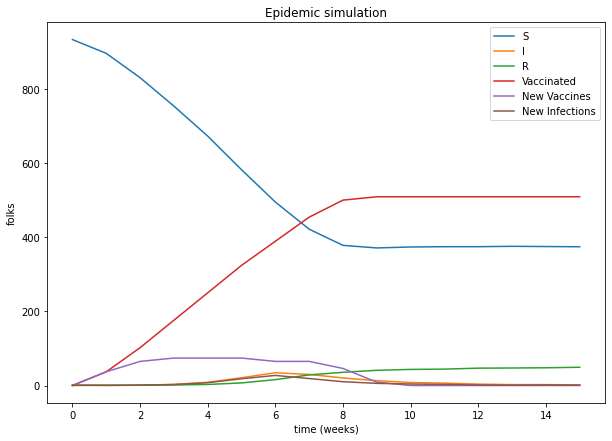

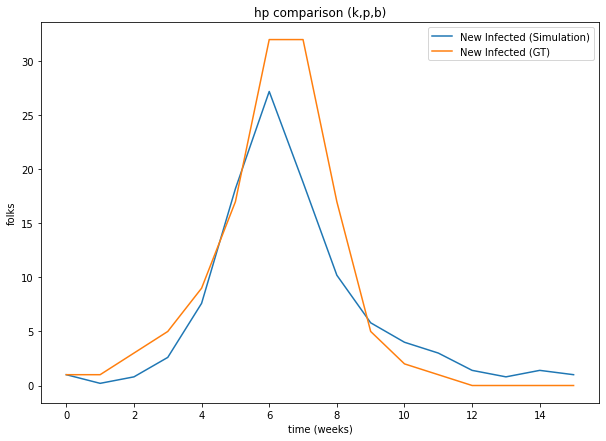

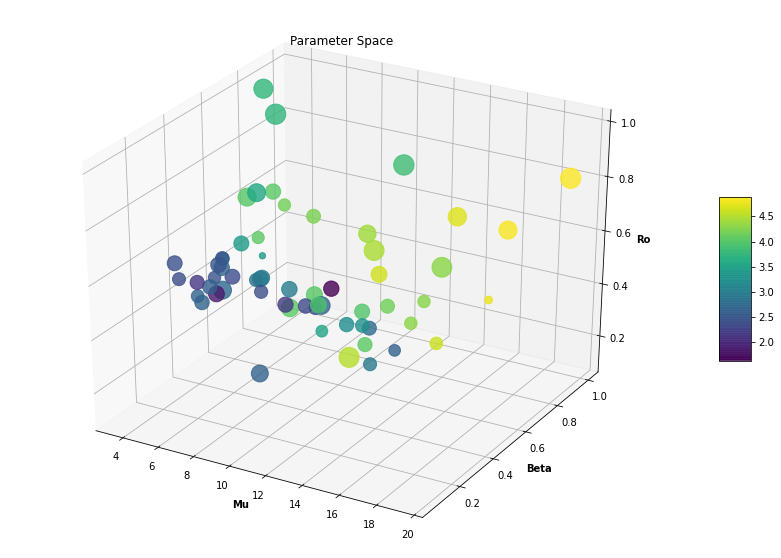

In [ ]:
research_random(5,N,5,12,attempts,None,NI_true,status,range(simulation_time),vacc)

{'mu': [2, 20], 'sigma': [0, 15], 'p': [0, 1], 'b': [0, 1]}
{'mu': [5.429149090805371, 18.433770772013858], 'sigma': [5.483489362438928, 11.769000834304235], 'p': [0.15971108726232874, 0.9805464022920081], 'b': [0.06773947092321397, 0.6411174097302127]}
{'mu': [6.561844572235422, 18.433770772013858], 'sigma': [5.765161866134384, 11.151563225703697], 'p': [0.5309961664918805, 0.7212429916441441], 'b': [0.06773947092321397, 0.3650364584363337]}
{'mu': [9.902827138184264, 15.302056001068374], 'sigma': [6.180263380489101, 10.622421791103525], 'p': [0.5326709708141739, 0.6904637566542307], 'b': [0.092314201844115, 0.2790014926040337]}
{'mu': [9.902827138184264, 14.209895639620491], 'sigma': [8.606648524190112, 10.494139281490787], 'p': [0.5349898568071713, 0.6726289636886496], 'b': [0.13562825129063474, 0.2790014926040337]}
{'mu': [9.902827138184264, 13.360532602400331], 'sigma': [8.737333912307907, 10.45491619679612], 'p': [0.5537796248312011, 0.6476020065440569], 'b': [0.17595298186615055

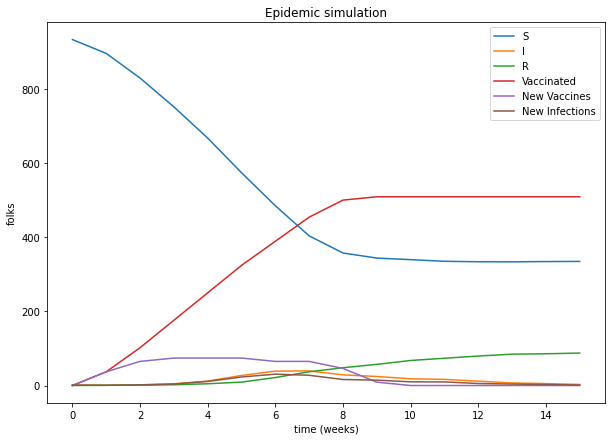

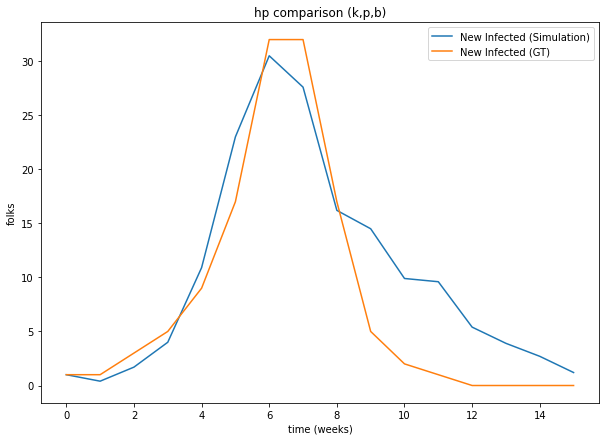

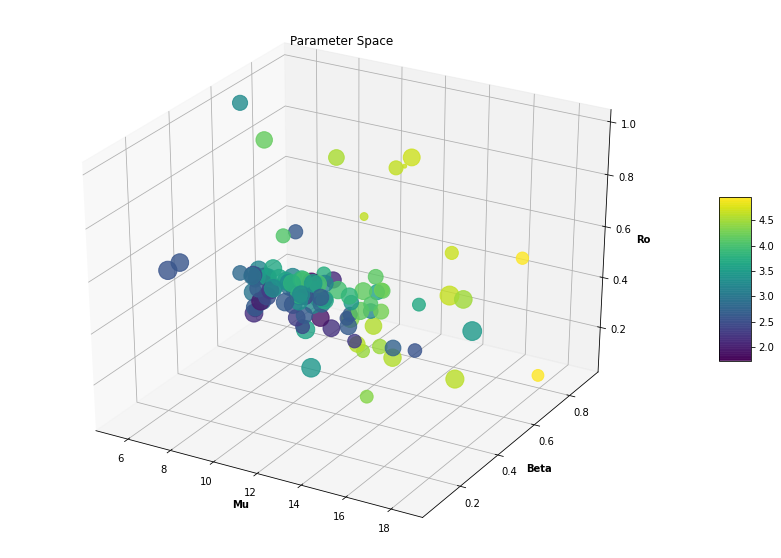

In [ ]:
N = 934
vacc = [5,9,16,24,32,40,47,54,59,60,60,60,60,60,60,60]
status = np.zeros(N,dtype=np.int32)
init_infected = choice(range(status.shape[0]),1)
status[init_infected] = 1
simulation_time = 16
attempts = 10
SIR = {'S':0,'I':1,'R':2, 'V':3}
NI_true = [1,1,3,5,9,17,32,32,17,5,2,1,0,0,0,0]
research_random(7,N,5,15,attempts,None,NI_true,status,range(simulation_time),vacc)

In [16]:
class RGSmallWorldModel():
  def __init__(self,N,mu,sigma=None):
    self.N = N
    self.mu = mu
    self.sigma = sigma if sigma else mu/4
    self.WCM = lil_matrix(np.empty((N,N)))
    self.available_targets = np.arange(N)
    self.residual_degrees = None
    self.G = None
    self.nodes_count = 0
    self.init_graph_distribution()
    self.init_graph()
    
  def init_graph(self):
    while self.nodes_count < self.N: # while the number of filled nodes is lower than N
      new_nodes = np.random.normal(self.mu, self.sigma, 1).astype(int)
      if self.nodes_count + new_nodes > self.N:
        new_nodes = self.N - self.nodes_count
      elif new_nodes < 1: 
        continue

      nodes = np.arange(self.nodes_count,self.nodes_count + new_nodes)
      
      new_graph_res_deg = self.residual_degrees[nodes[0]:nodes[-1]].copy()
      if(np.sum(new_graph_res_deg)==0):
        continue

      if new_nodes <= 2:
        new_sg = nx.Graph()
        new_sg.add_nodes_from(nodes)
        if new_nodes == 2:
          new_sg.add_edge(nodes[0],nodes[1])
      else:
        new_sg = self.create_sub_graph(nodes)

      if self.G and self.G.number_of_edges() > 0:
        ### addictional link to ensure the strongly connection
        norm_degrees = np.array([self.G.degree(x) for x in self.G.nodes])/(self.G.number_of_edges()*2)
        old_graph_node = choice(self.G.nodes,1,[x for x in norm_degrees])[0]
        if new_nodes > 2:
          new_graph_node = choice(nodes,1,self.normalize_weights(new_graph_res_deg))[0] # new sub graph node random accordingly to degree distribution
        else:
          new_graph_node = nodes[0]
        self.G = nx.compose(self.G,new_sg)
        self.G.add_edge(old_graph_node,new_graph_node)
        #self.residual_degrees[old_graph_node] -= 1
        #self.residual_degrees[new_graph_node] -= 1
        self.WCM[old_graph_node,new_graph_node] = 1
        self.WCM[new_graph_node,old_graph_node] = 1

      else:
        self.G = new_sg
  
      self.nodes_count += new_nodes

    #self.draw_circular()
    self.WCM = nx.adjacency_matrix(self.G)
    self.perturbate_graph()

  def create_sub_graph(self,nodes):
    sg = nx.Graph()
    sg.add_nodes_from(nodes)
    for node in nodes:
      if(self.residual_degrees[node] < 1): #saturated node
        continue
      sub_graph_degrees = self.residual_degrees[nodes[0]:nodes[-1]].copy() #select the nodes that are part of the subgraph 
      sub_graph_degrees[self.nodes_count - node] = 0 #avoid self loop
      if np.sum(sub_graph_degrees[sub_graph_degrees>0]) == 0: #saturated neighborhood end of cycle
        break
      num_links = np.min(np.random.randint(int(self.residual_degrees[node]/2),self.residual_degrees[node]), ) # min (randint(res degree), available_neighbors)
      num_links = num_links if num_links > 0 else 1
      targets = choice(nodes,num_links,self.normalize_weights(sub_graph_degrees)) # choose a random number of connections [1,max_degree] between the normalized probability of neighbors degrees
      if targets.shape[0] == 0: #no targets
        continue
      self.residual_degrees[node] -= targets.shape[0]
      for target in targets:
        if self.residual_degrees[target] < 1:
          sub_graph_degrees = self.residual_degrees[nodes[0]:nodes[-1]] #select the nodes that are part of the subgraph 
          if np.sum(sub_graph_degrees) == 0: #saturated neighborhood
            break
          target = choice(nodes,1,self.normalize_weights(sub_graph_degrees))[0]
        self.residual_degrees[target] -=1
        sg.add_edge(node,target)
        self.WCM[node,target] = 1
        self.WCM[target,node] = 1
    #self.draw(sg,title=f'{self.nodes_count}_{nodes.shape[0]}')
    return sg

  def perturbate_graph(self):
    for i in range(self.N):
      if(self.residual_degrees[i] < 1):
        continue
      # a target is available if its residual in degree is positive
      available_targets = np.argwhere(self.residual_degrees > 0).flatten()
      if available_targets.shape[0] == 0:
        break
      # randomly connect the link to the targets
      if(np.sum(self.residual_degrees[self.residual_degrees>0])==0):
        break
      targets = np.random.choice(available_targets,self.residual_degrees[i],self.normalize_weights(self.residual_degrees))
      self.residual_degrees[i] -= targets.shape[0]
      for target in targets:
        if self.residual_degrees[target] < 1:
          available_targets = self.available_targets[np.argwhere(self.residual_degrees > 0)].flatten()
          if available_targets.shape[0] == 0:
            break
          target = np.random.choice(available_targets,1)[0]
        self.WCM[i,target] = 1
        self.WCM[target,i] = 1
        self.residual_degrees[target] -=1
    self.G = nx.from_numpy_array(self.WCM.todense(), create_using=nx.Graph)

  def init_graph_distribution(self):
    s = np.random.normal(self.mu, self.sigma, self.N) #Select a number through a normal distribution, given a mean and a standard deviation
    n = s.astype(np.int32) #Cast it to integer
    n[n<1] = 1 #Check if the number of edges is suitable 
    nodes_to_add_remove = int(sum(s) - sum(n)) #adds randomly some connection in order to minimize the int cast error
    ex = np.random.choice(range(self.N), abs(nodes_to_add_remove)) #Inside all the possible nodes, select a number of nodes to add (for example, in N=100 nodes, take 8 nodes)
    for i in ex: #Iterate over the selected node
      if nodes_to_add_remove > 0:  
        n[i] += 1 
      else:
        if n[i] > 2: 
          n[i] -= 1
        else:
          while True:
            new_index = np.random.randint(self.N)
            if n[new_index] > 2:
              n[new_index] -= 1
              break
    self.residual_degrees = np.array(n)

  def print(self,*param):
    for i,x in enumerate(param):
      print(f"{i}) {x}")

  def normalize_weights(self,arr):
    w = arr.copy()
    w[w<0] = 0
    den = np.sum(w) 
    den = den if den > 0 else 1
    return [arr/den] 

  def draw(self, gr=None, title=None):
    if not gr:
      gr = self.G
    fig = plt.figure()
    title = title if title else "graph"
    fig.suptitle(title, fontsize=20)
    nx.draw(gr)
    
  
  def draw_circular(self, gr=None, title=None):
    if not gr:
      gr = self.G
    fig = plt.figure()
    title = title if title else "graph"
    fig.suptitle(title, fontsize=20)
    pos = nx.circular_layout(self.G)
    nx.draw(gr,pos)

In [17]:
vacc = [5,9,16,24,32,40,47,54,59,60,60,60,60,60,60,60]
NI_true = [1,1,3,5,9,17,32,32,17,5,2,1,0,0,0,0]
N = 934
k = 6
mu = 10
sigma = 1
#nx.draw(CMG)
status = np.zeros(N)
beta = 0.5
p = 0.7
simulation_time = 16 #weeks
attempts = 10
SIR = {'S':0,'I':1,'R':2}
test_graph = RGSmallWorldModel(N,10,2).G
#test_graph.draw()
#test_graph.draw_circular(title="main")
print(np.mean([test_graph.degree(x) for x in range(N)]))
print(np.std([test_graph.degree(x) for x in range(N)]))
print(len(test_graph.nodes))
init_infected = choice(test_graph.nodes,1, replace=False)
for inf in init_infected:
    status[inf] = 1
print(init_infected)
research_random(5,N,5,13,attempts,None,NI_true,status,range(simulation_time),vacc)

7.423982869379015
1.6742484599031668
934
[447]
{'mu': [2, 20], 'sigma': [0, 15], 'p': [0, 1], 'b': [0, 1]}


KeyboardInterrupt: 

In [ ]:
!jupyter nbconvert --to pdf /ex5nets.ipynb

[NbConvertApp] Converting notebook /ex5nets.ipynb to pdf
[NbConvertApp] Support files will be in ex5nets_files/
[NbConvertApp] Making directory ./ex5nets_files
[NbConvertApp] Making directory ./ex5nets_files
[NbConvertApp] Making directory ./ex5nets_files
[NbConvertApp] Making directory ./ex5nets_files
[NbConvertApp] Making directory ./ex5nets_files
[NbConvertApp] Making directory ./ex5nets_files
[NbConvertApp] Making directory ./ex5nets_files
[NbConvertApp] Making directory ./ex5nets_files
[NbConvertApp] Making directory ./ex5nets_files
[NbConvertApp] Writing 85126 bytes to ./notebook.tex
[NbConvertApp] Building PDF
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/jupyter_core/application.py", line 267, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py"

In [ ]:
pip install xelatex

ERROR: Could not find a version that satisfies the requirement xelatex (from versions: none)
ERROR: No matching distribution found for xelatex
